# Using Genetic Programming to fit a function to noisy data.

DEAP install

In [61]:
!pip install deap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Let's make some noisy signals.

In [134]:
import numpy as np
from matplotlib import pyplot as plt

def decay_exp_l(x,l):
    """
    decaying exponential with specified lambda
    y = exp(-x/l)
    """
    x = np.asarray(x,dtype='float') + 0.01
    y = np.exp(-x/l)
    return y

def cubic(x,a,b,c,d):
    """
    a cubic function.
    """
    return a*x**3 + b*x**2 + c*x + d

def add_noise(x):
    """
    Add noise to a given input.
    Noise magnitude is 
    ~ N(0,max(x)/10)
    I.e scales with input magnitude
    """
    l = len(x)
    return x + (1/20 * max(x)) * np.random.randn(l)

def normalise(x):
    return x / np.max(x)

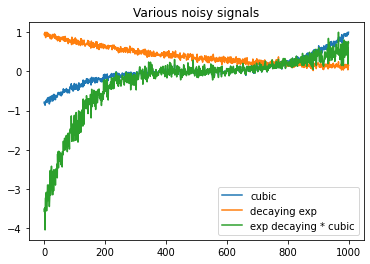

In [135]:
x_vec=np.linspace(-100,100,1000)

cubic_x = add_noise(cubic(x_vec, 1, 10, 100,1000))
exp_x = add_noise(decay_exp_l(x_vec, 100))
y_vec = cubic_x * exp_x

plt.plot(normalise(cubic_x), label="cubic")
plt.plot(normalise(exp_x), label="decaying exp")
plt.plot(normalise(cubic_x * exp_x), label="exp decaying * cubic")
plt.title("Various noisy signals")
plt.legend()
plt.show()

Now lets make a function to fit this.

In [137]:
import operator
import math
import random
from sympy import sympify
import numpy as np
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp
from matplotlib import pyplot as plt
from random import randint as rand

def protectedDiv(a, b):
    """
    protected division for numpy arrays
    """
    a = np.asarray(a,dtype='float')
    b = np.asarray(b,dtype='float')
    c = np.divide(a, b, out=np.ones_like(a), where=b!=0)
    return c

def decay_exp(x):
    """
    decaying exponential
    y = exp(-x)
    """
    x = np.asarray(x,dtype='float') + 0.01
    y = np.exp(-x/100)
    return y

def evalSymbReg(individual,x_points,y_points):
    """evaluate the fitness of the individual"""
    # Transform the tree expression in a callable function
    func = toolbox.compile(expr=individual)
    # Evaluate the mean squared error between the expression and
    # the real values (y points)
    sqerrors = ((func(x_points[i]) - y_points[i])**2 for i in range(len(x_points)))
    mean_err = math.fsum(sqerrors) / len(x_points)
    return mean_err,

def create_primset(name):
    #create primitive set
    pset = gp.PrimitiveSet("MAIN", 1)
    pset.addPrimitive(operator.add, 2)
    pset.addPrimitive(operator.sub, 2)
    pset.addPrimitive(operator.mul, 2)
    #pset.addPrimitive(protectedDiv, 2)
    pset.addPrimitive(decay_exp, 1)
    pset.addPrimitive(math.cos,1)
    pset.addPrimitive(math.sin,1)
    # deap bug: must change randguy string every time.. (raise github issue?)
    pset.addEphemeralConstant(name, lambda: random.randint(-2,2))
    #use x instead of ARG0 as our variable name
    pset.renameArguments(ARG0='x')
    return pset    

def create_stats():
    #create tools for computing statistics on populations
    stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
    stats_size = tools.Statistics(len)
    mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
    mstats.register("avg", np.mean)
    mstats.register("std", np.std)
    mstats.register("min", np.min)
    mstats.register("max", np.max)
    return mstats

def human_readable(individual):
    """ convert a candidate function into a human readable string""" 
    #dictionary to translate deap output to human readable
    #using sympy
    locals = {
        'sub': lambda x, y : x - y,
        'protectedDiv': lambda x, y : x/y if y!=0 else 1,
        'mul': lambda x, y : x*y,
        'add': lambda x, y : x + y,
        'pow': lambda x, y : x**y,
        'neg': lambda x    : -x,
    }
    print(f'original: {individual}')
    expr = sympify(str(individual), locals=locals)
    print(f'simplified: {expr}')
    return expr

def create_toolbox(pset,tree_depth,x,y):
    """given a pset, 
    the max tree depth, 
    and dataset (x and y vector)
    create a toolbox to operate while evolving
    """
    #define evolution parameters with toolbox
    toolbox = base.Toolbox()
    toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("compile", gp.compile, pset=pset)
    #evaluate performance
    toolbox.register("evaluate", evalSymbReg, x_points=x, y_points=y)
    #use double tournament selection to select first based on fitness, and second based on size.
    #toolbox.register("select", tools.selDoubleTournament, fitness_size=4, parsimony_size=1.4, fitness_first=True)
    toolbox.register("select", tools.selTournament, tournsize=2)
    toolbox.register("mate", gp.cxOnePoint)
    toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
    toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
    toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=tree_depth))
    toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=tree_depth))
    return toolbox

def plot_comparison(x_vec,y_vec,func,titstr):
    """compare a function's prediction with the real points"""
    x_vec = np.asarray(x_vec)
    pred = [func(i) for i in x_vec]
    plt.plot(x_vec,y_vec,label="realdata")
    plt.plot(x_vec,pred,label="prediction")
    plt.title(f"{titstr}\n Guessed ${best_str}$")
    plt.legend()
    plt.show()

Set up GP algorithm for running.

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


   	      	                                  fitness                                  	                      size                     
   	      	---------------------------------------------------------------------------	-----------------------------------------------
gen	nevals	avg        	gen	max        	min        	nevals	std        	avg  	gen	max	min	nevals	std    
0  	2000  	3.66018e+11	0  	8.87747e+11	1.28541e+11	2000  	1.28457e+10	3.454	0  	7  	2  	2000  	1.43558
1  	1054  	3.65521e+11	1  	3.71382e+11	1.28541e+11	1054  	7.53558e+09	3.6615	1  	11 	1  	1054  	1.69968
2  	1077  	3.65555e+11	2  	7.82458e+11	1.28541e+11	1077  	1.30782e+10	4.0535	2  	15 	1  	1077  	1.99816
3  	1042  	3.64869e+11	3  	8.85014e+11	1.25847e+11	1042  	1.93603e+10	4.4375	3  	15 	1  	1042  	2.23408
4  	1023  	3.63944e+11	4  	8.87656e+11	1.25847e+11	1023  	2.71183e+10	4.814 	4  	15 	1  	1023  	2.46199
5  	1081  	4.84239e+12	5  	4.52328e+15	1.21215e+11	1081  	1.41594e+14	5.31  	5  	15 	1  	1081  	2.64138
6  	

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


13 	982   	inf        	13 	inf        	1.18007e+11	982   	nan        	8.8445	13 	29 	1  	982   	3.9737 
14 	1048  	2.30056e+16	14 	9.19988e+18	1.26054e+10	1048  	4.58629e+17	8.86  	14 	29 	1  	1048  	4.14408
15 	1046  	3.67729e+16	15 	3.67226e+19	1.25933e+10	1046  	9.17284e+17	8.933 	15 	31 	1  	1046  	4.28153


<string>:1: RuntimeWarning: overflow encountered in double_scalars


16 	1009  	inf        	16 	inf        	1.259e+10  	1009  	nan        	9.0865	16 	27 	1  	1009  	4.37824
17 	1038  	inf        	17 	inf        	1.259e+10  	1038  	nan        	9.122 	17 	32 	1  	1038  	4.38693
18 	1043  	inf        	18 	inf        	1.07619e+10	1043  	nan        	9.3915	18 	27 	1  	1043  	4.36981
19 	1032  	inf        	19 	inf        	1.259e+10  	1032  	nan        	9.87  	19 	29 	1  	1032  	4.53609
20 	1069  	inf        	20 	inf        	1.16229e+10	1069  	nan        	10.33 	20 	29 	1  	1069  	4.81987
   	      	                                  fitness                                  	                      size                     
   	      	---------------------------------------------------------------------------	-----------------------------------------------
gen	nevals	avg        	gen	max        	min        	nevals	std        	avg   	gen	max	min	nevals	std    
0  	2000  	3.66018e+11	0  	8.87747e+11	1.28541e+11	2000  	1.28457e+10	3.454 	0  	7  	2  	2000  	1.43558
1 

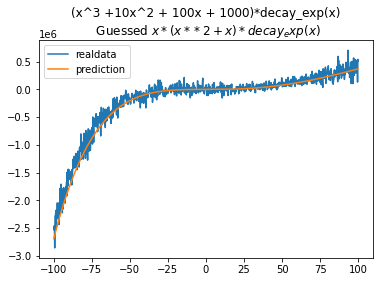

In [142]:
generation_pop = 2000
gen_num = 20
depth = 8
r = 123

#create primitive set of operations for tree generation
randname = str(100*rand(0,100000) + 123*rand(0,100))+"name"
#need new name for randon number constant each time due to DEAP bug
pset = create_primset(randname)

#define fitness function and create individual who holds the genotype
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
#individual is a tree
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)
#define evolution parameters with toolbox
toolbox = create_toolbox(pset,depth,x_vec,y_vec) 

#------------------------------------------
#run it
random.seed(r)
#initialise population and hall of fame ()
pop = toolbox.population(n=generation_pop)
hof = tools.HallOfFame(1)

#grab statistics
mstats = create_stats()

#eaSimple(population, toolbox, cxpb, mutpb, ngen, stats=None,halloffame=None, verbose=__debug__):
"""This algorithm implements a simple evolutionary algorithm
:param population: A list of individuals.
:param toolbox: A :class:`~deap.base.Toolbox` that contains the evolution operators.
:param cxpb: The probability of mating two individuals. Set to 50%
:param mutpb: The probability of mutating an individual. Set to 20%
:param ngen: The number of generation.
:param stats: A :class:`~deap.tools.Statistics` object 
:param halloffame: A :class:`~deap.tools.HallOfFame` object that will contain the best individuals, optional.
:param verbose: Whether or not to log the statistics.
:returns: population: The final population
:returns: run_log: statistics of the evolution process
"""
population, run_log = algorithms.eaSimple(pop, toolbox, 0.4, 0.2, gen_num, stats=mstats,
                                halloffame=hof, verbose=True)
print(run_log)

#try to get best individual into a printable form
best_ind = tools.selBest(population, 1)[0]
best_str = human_readable(best_ind)
print("best str", best_str)

#now plot the function vs the data
func = toolbox.compile(expr=best_ind)
#save plot
#real function
real="(x^3 +10x^2 + 100x + 1000)*decay_exp(x)"
plot_comparison(x_vec,y_vec,func,real)